In [1]:
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
import re
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose, ZeroPadding1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 符号付に変換する関数
def unsigned2signed(x):
    if x > 32767:
        return x - 65536
    return x

In [3]:
# 学習データの読み込み
def load_binary_data(folder_path):
    data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in data or data_index > data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    file_names.append(file_name)  # ファイル名をリストに追加

    return data, file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# フォルダを選択するためのダイアログを表示
folder_selected = filedialog.askdirectory()

if folder_selected:
    print("選択したフォルダ:", folder_selected)
    # フォルダ内のデータを読み込む
    data, data_filenames = load_binary_data(folder_selected)
    if data:
        print("データの読み込みが完了しました。")
    else:
        print("データが見つかりませんでした。")
else:
    print("フォルダが選択されませんでした。")

# Tkinterを終了
root.quit()

sensor_data_dict = {}  # センサーデータを格納するディクショナリ
for key, sensor_data in data.items():
    extension_number = sensor_data[-1]  # 拡張子の番号
    for i, sensor_value in enumerate(sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if sensor_key not in sensor_data_dict:
            sensor_data_dict[sensor_key] = []  # キーが存在しない場合、空のリストを作成
        sensor_data_dict[sensor_key].append(sensor_value)  # キーに対応するリストにセンサーデータを追加

# データの形状を決定
num_samples = len(sensor_data_dict)
num_sensors = 8  # センサーの数

# 2次元のリストを初期化
data_matrix = [[None] * num_sensors for _ in range(num_samples)]

# センサーデータのみを保存する新しい変数を作成
sensor_data = []

# データを2次元リストと新しい変数に配置
for i, (key, sensor_values) in enumerate(sensor_data_dict.items()):
    data_matrix[i] = [key] + sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    sensor_data.append(sensor_values)  # センサーデータのリストを新しい変数に格納
    
# 3次元のリストを2次元のリストに変換する
reshaped_sensor_data = []
for sample in sensor_data:
    for sensor_values in sample:
        reshaped_sensor_data.append(sensor_values)

sensor_data = reshaped_sensor_data

選択したフォルダ: C:/Users/r-fujita/Desktop/learning_data
データの読み込みが完了しました。


In [4]:
# テストデータの読み込み
def load_test_data(test_folder_path):
    test_data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    test_file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(test_folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in test_data or data_index > test_data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    test_data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    test_file_names.append(file_name)  # ファイル名をリストに追加

    return test_data, test_file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# テストデータのフォルダを選択するためのダイアログを表示
test_folder_path = filedialog.askdirectory()

if test_folder_path:
    print("選択したテストデータのフォルダ:", test_folder_path)
    # テストデータを読み込む
    test_data, test_data_filenames = load_test_data(test_folder_path)
    if test_data:
        print("テストデータの読み込みが完了しました。")
    else:
        print("テストデータが見つかりませんでした.")
else:
    print("テストデータのフォルダが選択されませんでした.")

test_sensor_data_dict = {}  # テストデータのセンサーデータを格納するディクショナリ
for key, test_sensor_data in test_data.items():
    extension_number = test_sensor_data[-1]  # 拡張子の番号
    for i, test_sensor_value in enumerate(test_sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        test_sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if test_sensor_key not in test_sensor_data_dict:
            test_sensor_data_dict[test_sensor_key] = []  # キーが存在しない場合、空のリストを作成
        test_sensor_data_dict[test_sensor_key].append(test_sensor_value)  # キーに対応するリストにテストデータのセンサーデータを追加

# データの形状を決定
num_test_samples = len(test_sensor_data_dict)
num_sensors = 8  # センサーの数

# テストデータの2次元のリストを初期化
test_data_matrix = [[None] * num_sensors for _ in range(num_test_samples)]

# テストデータのセンサーデータのみを保存する新しい変数を作成
test_sensor_data = []

# テストデータを2次元リストと新しい変数に配置
for i, (key, test_sensor_values) in enumerate(test_sensor_data_dict.items()):
    test_data_matrix[i] = [key] + test_sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    test_sensor_data.append(test_sensor_values)  # テストデータのセンサーデータのリストを新しい変数に格納

# 3次元のリストを2次元のリストに変換する
reshaped_sensor_data = []
for sample in test_sensor_data:
    for test_sensor_values in sample:
        reshaped_sensor_data.append(test_sensor_values)

test_sensor_data = reshaped_sensor_data

選択したテストデータのフォルダ: C:/Users/r-fujita/Desktop/test_data
テストデータの読み込みが完了しました。


In [5]:
# 空のリストがないか確認する。
empty_lists_sensor_data_indices = [i for i, data in enumerate(sensor_data) if not data]
empty_lists_test_sensor_data_indices = [i for i, data in enumerate(test_sensor_data) if not data]

print("sensor_data内の空のリストの数:", len(empty_lists_sensor_data_indices))
print("test_sensor_data内の空のリストの数:", len(empty_lists_test_sensor_data_indices))

print("sensor_data内の空のリストのインデックス:", empty_lists_sensor_data_indices)
print("test_sensor_data内の空のリストのインデックス:", empty_lists_test_sensor_data_indices)

sensor_data内の空のリストの数: 0
test_sensor_data内の空のリストの数: 0
sensor_data内の空のリストのインデックス: []
test_sensor_data内の空のリストのインデックス: []


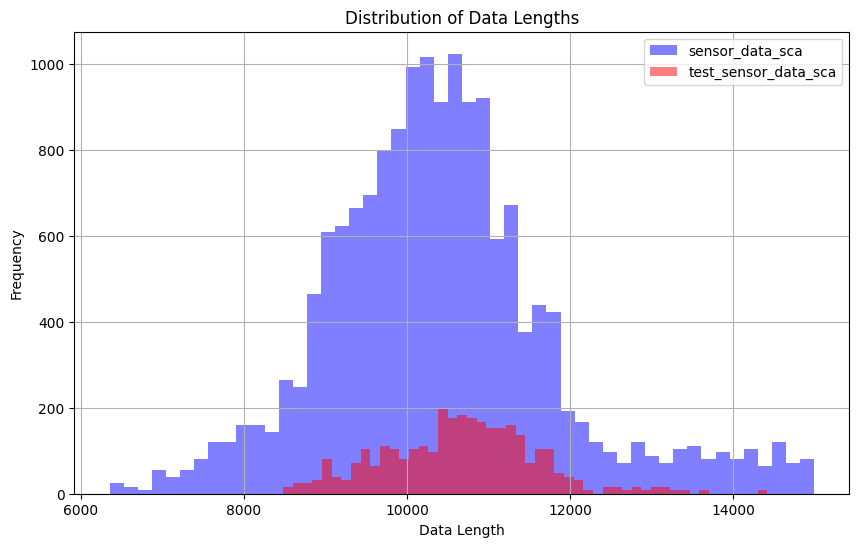

In [8]:
# sensor_data_scaとtest_sensor_data_scaのデータ長を取得
sensor_data_lengths = [len(data) for data in sensor_data]
test_sensor_data_lengths = [len(data) for data in test_sensor_data]

# ヒストグラムをプロット
plt.figure(figsize=(10, 6))
plt.hist(sensor_data_lengths, bins=50, alpha=0.5, color='blue', label='sensor_data_sca')
plt.hist(test_sensor_data_lengths, bins=50, alpha=0.5, color='red', label='test_sensor_data_sca')
plt.xlabel('Data Length')
plt.ylabel('Frequency')
plt.title('Distribution of Data Lengths')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# データ長が5000未満及び15000以上のデータを削除する。

# データ長が15000以上のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(sensor_data) if len(data) >= 15000]
# 対応するインデックスのデータを削除する
for index in sorted(indices_to_remove, reverse=True):
    del sensor_data[index]
# データ長が5000未満のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(sensor_data) if len(data) < 5000]
for index in sorted(indices_to_remove, reverse=True):
    del sensor_data[index]

# データ長が15000以上のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(test_sensor_data) if len(data) >= 15000]
# 対応するインデックスのデータを削除する
for index in sorted(indices_to_remove, reverse=True):
    del test_sensor_data[index]
# データ長が5000未満のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(test_sensor_data) if len(data) < 5000]
for index in sorted(indices_to_remove, reverse=True):
    del test_sensor_data[index]

In [9]:
# データの標準化
# 学習データ
sensor_data_sca = []
for i in range(len(sensor_data)):
    mean = np.mean(sensor_data[i])
    std = np.std(sensor_data[i])

    #標準化処理を実行
    standardization_sensor_data = (sensor_data[i] - mean) / std
    sensor_data_sca.append(standardization_sensor_data)

# テストデータ
test_sensor_data_sca = []
for i in range(len(test_sensor_data)):
    mean = np.mean(test_sensor_data[i])
    std = np.std(test_sensor_data[i])

    #標準化処理を実行
    standardization_test_sensor_data = (test_sensor_data[i] - mean) / std
    test_sensor_data_sca.append(standardization_test_sensor_data)


# データ長を揃える(最長のデータ+1000)
# 最大の波形データ長を見つける
max_length = max(len(data) for data in sensor_data_sca + test_sensor_data_sca)
max_length = max_length+1000

# ゼロパディングを行う（学習データ）
padded_sensor_data = []
for data in sensor_data_sca:
    padding_length = max_length - len(data)
    padding_beginning = padding_length // 2
    padding_end = padding_length - padding_beginning
    padded_data = np.pad(data, (padding_beginning, padding_end), mode='constant', constant_values=0)
    padded_sensor_data.append(padded_data)

# ゼロパディングを行う（テストデータ）
padded_test_sensor_data = []
for data in test_sensor_data_sca:
    padding_length = max_length - len(data)
    padding_beginning = padding_length // 2
    padding_end = padding_length - padding_beginning
    padded_data = np.pad(data, (padding_beginning, padding_end), mode='constant', constant_values=0)
    padded_test_sensor_data.append(padded_data)


# 学習データとテストデータをNumPyの配列に変換
padded_sensor_data = np.array(padded_sensor_data)
padded_test_sensor_data = np.array(padded_test_sensor_data)

# 管ごとの8チャンネルのデータを結合
concatenated_data_per_subject = []
for i in range(len(padded_sensor_data) // 8):  # 管の数だけループ
    subject_data = padded_sensor_data[i * 8:(i + 1) * 8]  # 同じ管の8チャンネルのデータを取得
    concatenated_data = np.stack(subject_data, axis=-1)  # 8チャンネルのデータを1つの配列に連結
    concatenated_data_per_subject.append(concatenated_data)

# データをデータ長×8チャンネルの形状に整形する
reshaped_sensor_data = []
for data in concatenated_data_per_subject:
    reshaped_sensor_data.append(data.reshape(-1, 8))  # データ長×8チャンネルの形状に変換し、リストに追加

reshaped_sensor_data = np.array(reshaped_sensor_data)  # リストをNumPy配列に変換

# 管ごとの8チャンネルのデータを結合
concatenated_data_per_subject = []
for i in range(len(padded_test_sensor_data) // 8):  # 管の数だけループ
    subject_data = padded_test_sensor_data[i * 8:(i + 1) * 8]  # 同じ管の8チャンネルのデータを取得
    concatenated_data = np.stack(subject_data, axis=-1)  # 8チャンネルのデータを1つの配列に連結
    concatenated_data_per_subject.append(concatenated_data)

# データをデータ長×8チャンネルの形状に整形する
reshaped_test_sensor_data = []
for data in concatenated_data_per_subject:
    reshaped_test_sensor_data.append(data.reshape(-1, 8))  # データ長×8チャンネルの形状に変換し、リストに追加

reshaped_test_sensor_data = np.array(reshaped_test_sensor_data)  # リストをNumPy配列に変換

NameError: name 'maxlength' is not defined

In [13]:
def stacked_what_where_autoencoder(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(32, 10, activation='selu', padding='same')(inputs)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)  
    conv2 = Conv1D(64, 10, activation='selu', padding='same')(pool1)
    pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)  

    # Decoder
    conv3 = Conv1DTranspose(64, 10, strides=2, activation='selu', padding='same')(pool2)
    conv4 = Conv1DTranspose(32, 10, strides=2, activation='selu', padding='same')(conv3)
    decoded = Conv1DTranspose(input_shape[-1], 10, padding='same')(conv4)  # 出力形状を入力形状と一致させる

    # Autoencoder Model
    autoencoder = Model(inputs, decoded)
    return autoencoder


In [14]:
# 入力データの形状を取得
input_shape = reshaped_sensor_data.shape[1:]

# Stacked What-Where Autoencoderを構築
autoencoder = stacked_what_where_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# モデルのサマリを表示
autoencoder.summary()

# モデルの学習
history = autoencoder.fit(reshaped_sensor_data, reshaped_sensor_data, epochs=25, batch_size=16, shuffle=True, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15992, 8)]        0         
                                                                 
 conv1d (Conv1D)             (None, 15992, 32)         2592      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7996, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7996, 64)          20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3998, 64)         0         
 1D)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 7996, 64)         41024 

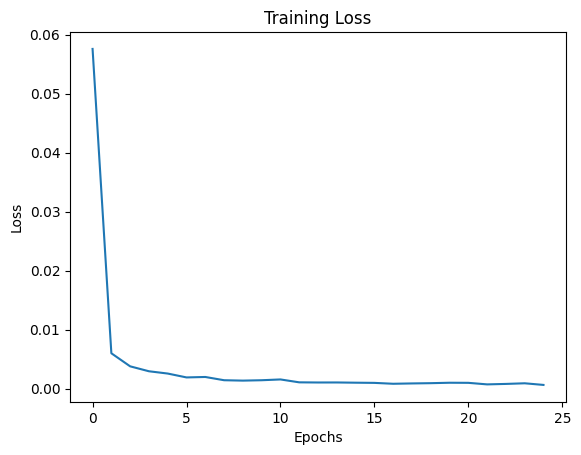

In [15]:
# 損失関数の値を取得
loss = history.history['loss']

# エポックごとの損失関数の変化をプロット
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [19]:
# テストデータを使って再構築を行う
reconstructed_test_data = autoencoder.predict(reshaped_test_sensor_data)

13/13 [==============================] - 0s 36ms/step


In [21]:
# 学習データの再構成を行う
reconstructed_data = autoencoder.predict(reshaped_sensor_data)

64/64 [==============================] - 1s 14ms/step


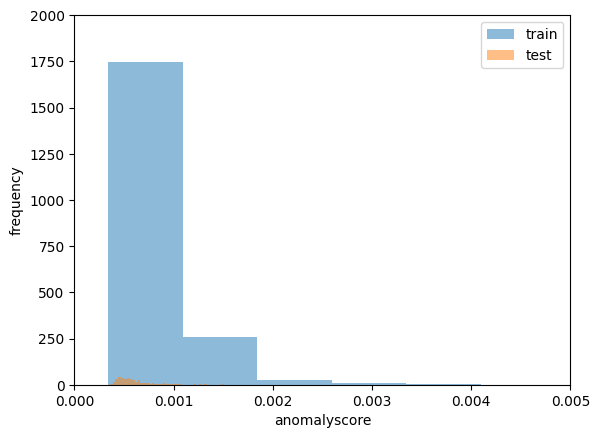

In [22]:
# 学習データの再構築誤差（平均二乗誤差）の計算
mse = np.mean(np.square(reshaped_sensor_data - reconstructed_data), axis=(1, 2))  # データごとの平均二乗誤差を計算
# テストデータの再構築誤差（平均二乗誤差）の計算
mse_test = np.mean(np.square(reshaped_test_sensor_data - reconstructed_test_data), axis=(1, 2))  # データごとの平均二乗誤差を計算

# ヒストグラムの作成
# 学習データのヒストグラム
plt.hist(mse, bins=100, alpha=0.5, label='train')  # 学習データのヒストグラムをプロット
# テストデータのヒストグラム
plt.hist(mse_test, bins=100, alpha=0.5, label='test')  # テストデータのヒストグラムをプロット
plt.xlim(0,0.005)
plt.ylim(0,2000)
plt.xlabel('anomalyscore')
plt.ylabel('frequency')
plt.legend()  # 凡例を表示
plt.show()

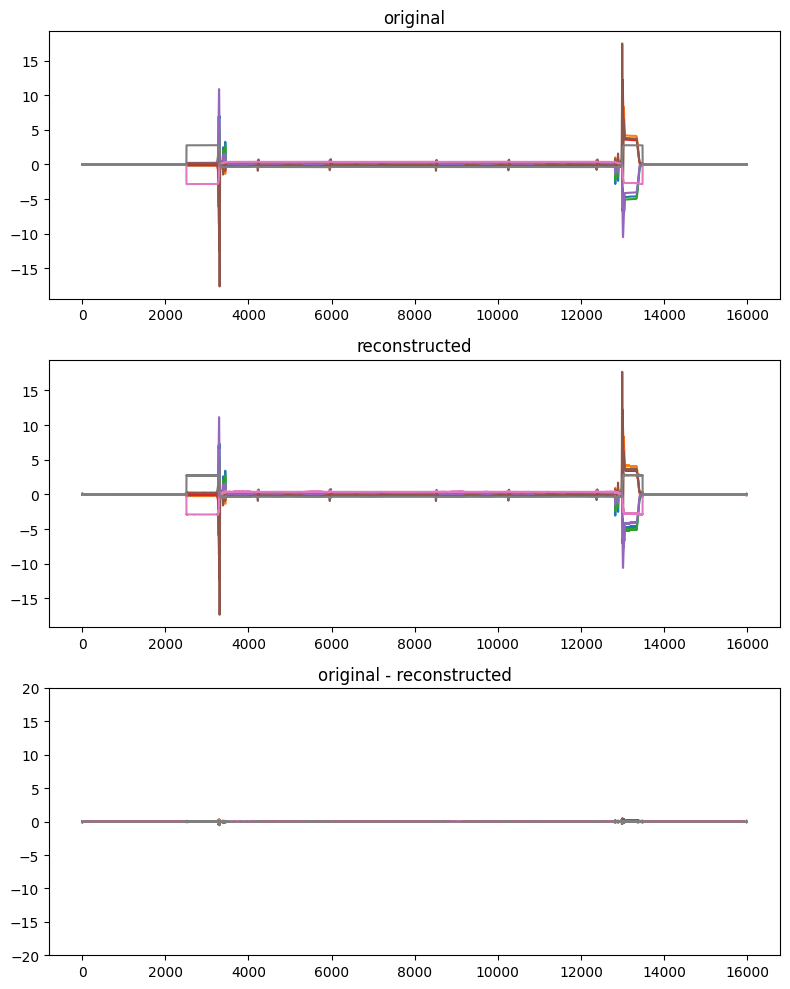

In [37]:
# Figureを作成し、2つのサブプロットを配置する
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

# 上側のサブプロットにプロットする
axes[0].plot(reshaped_sensor_data[1000])
axes[0].set_title('original')

# 中側のサブプロットにプロットする
axes[1].plot(reconstructed_data[1000])
axes[1].set_title('reconstructed')

# 下側のサブプロットにプロットする
axes[2].plot(reshaped_sensor_data[1000]-reconstructed_data[1000])
axes[2].set_title('original - reconstructed')
axes[2].set_ylim(-20,20)
# グラフのレイアウトを整える
plt.tight_layout()

# グラフを表示する
plt.show()


In [43]:
whos

Variable                               Type          Data/Info
--------------------------------------------------------------
Adam                                   type          <class 'keras.optimizers.optimizer_v2.adam.Adam'>
Conv1D                                 type          <class 'keras.layers.conv<...>olutional.conv1d.Conv1D'>
Conv1DTranspose                        type          <class 'keras.layers.conv<...>anspose.Conv1DTranspose'>
Input                                  function      <function Input at 0x0000017E9CAC6200>
MaxPooling1D                           type          <class 'keras.layers.pool<...>_pooling1d.MaxPooling1D'>
Model                                  type          <class 'keras.engine.training.Model'>
UpSampling1D                           type          <class 'keras.layers.resh<...>sampling1d.UpSampling1D'>
ZeroPadding1D                          type          <class 'keras.layers.resh<...>padding1d.ZeroPadding1D'>
autoencoder                            Func